# Udacity Deep Reinforcement Learning Nano-degree

## Navigation Project Report

---

Ellen Zhang (yarong.zhang@gmail.com)

The goal of this project was to train an agent to navigate a simple world environment, collecting yellow bananas while avoiding blue bananas. 

The task is episodic, and in order to solve the environment, the agent must get `an average score of +13 over 100 consecutive episodes`.

### 1. Environment

``` from unityagents import UnityEnvironment ```


Unity Machine Learning Agents (ML-Agents) is an open-source Unity plugin that enables games and simulations to serve as environments for training intelligent agents.

For game developers, these trained agents can be used for multiple purposes, including controlling NPC behavior (in a variety of settings such as multi-agent and adversarial), automated testing of game builds and evaluating different game design decisions pre-release.

In this project, I use Unity's rich environments to design, train, and evaluate my deep reinforcement learning algorithms. Environments contain `brains` which are responsible for deciding the actions of their associated agents.

I did this project in my 64-bits Win10 and in Udacity workspace seperately. In win10, whatever it is 32-bit or 64-bit Unity enviroments, they all work well. 

In [1]:
from unityagents import UnityEnvironment
import numpy as np

In [2]:
import torch

import matplotlib.pyplot as plt
%matplotlib inline

from collections import deque
import time

In [3]:
from dqn_agent import Agent

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [4]:
env = UnityEnvironment(file_name="Banana_Windows_x86_64/Banana.exe") #works in win10 64-bit
# env = UnityEnvironment(file_name="Banana_Windows_x86/Banana.exe")  #works in win10 64-bit

# env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64") #works in Udacity workspace

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [6]:
print(brain_name)

BananaBrain


### 2.The State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

In [7]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [8]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


### 3. Algorithm!

The solution implemented is a simple Deep Q-Learning (DQN) algorithm based on [ research paper ](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf).
The model architecture is very simple, just `3 fully-connected layers` with `Relu` activation function describes as below.

```
QNetwork(
  (fc1): Linear(in_features=37, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)

```
The algorithm has two main processes that are interleaved.

- One is where we sample the environment by performing actions and store away the observed, experienced tuples in a replay memory.
- The other is where we select the small batch of tuples from this memory, randomly, and learn from that batch using a gradient descent update step. 




![Algorithm](./images/dqn_algorithm.PNG)

Algorithm screenshot comes from [Udacity video course](https://classroom.udacity.com/nanodegrees/nd893-ent/parts/b5175725-8f50-4cd9-8666-fd4c1375039c/modules/56dab924-27c9-43ab-b898-3bdab18f6fd2/lessons/4adf70aa-0c4c-4a48-8bbe-e3619874f234/concepts/637ff801-c1e1-4eb8-90cb-c9bcda92ca77)

In [9]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    
    avgs_moving = []                   # list of averages of moving
        
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset enviroment
        state = env_info.vector_observations[0]           # get current state
#         state = env.reset()
        
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action.astype(int))[brain_name]        # send the action to the environment

            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            
            
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
                
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        mean_scores = np.mean(scores_window)
        avgs_moving.append(mean_scores)
        
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.10:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
            
    return scores, avgs_moving

In [10]:
start = time.time()

agent = Agent(state_size=state_size, action_size=action_size, seed=42)
print(agent.qnetwork_local)
scores, avgs_moving = dqn(n_episodes=1000, eps_start=1.0, eps_end=0.02, eps_decay=0.95)

end = time.time()
elapsed = (end - start) / 60.0 # in minutes
print("Elapsed Time: {0:3.2f} mins.".format(elapsed))

QNetwork(
  (fc1): Linear(in_features=37, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)
Episode 100	Average Score: 6.41
Episode 200	Average Score: 11.45
Episode 300	Average Score: 12.67
Episode 320	Average Score: 13.12
Environment solved in 220 episodes!	Average Score: 13.12
Elapsed Time: 6.97 mins.


### 4. The result

The simple model used successfully solved the problem after around 180 to 220 episodes based on the fixed hyper parameters and slightly changed epsilon value.

- The hyper-parameters is fixed during the training and the testing.
```
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network
```


- The training score dispicts as pic shows.

![Training score](./images/training_scores.png)

```scores, avgs_moving = dqn(n_episodes=1000, eps_start=1.0, eps_end=0.03, eps_decay=0.95)```
```
Episode 100	Average Score: 6.42
Episode 200	Average Score: 10.82
Episode 280	Average Score: 13.11
Environment solved in 180 episodes!	Average Score: 13.11

```

```scores, avgs_moving = dqn(n_episodes=1000, eps_start=1.0, eps_end=0.02, eps_decay=0.95)```

```
Episode 100	Average Score: 4.96
Episode 200	Average Score: 9.27
Episode 287	Average Score: 13.14
Environment solved in 187 episodes!	Average Score: 13.14
```
```
Episode 100	Average Score: 6.41
Episode 200	Average Score: 11.45
Episode 300	Average Score: 12.67
Episode 320	Average Score: 13.12
Environment solved in 220 episodes!	Average Score: 13.12

```

- The testing result(10 episodes):
All testing results are not over 13. May need more trainings.

![Testing_score](./images/testing_score_13.png) 

After changing the training break condition, the test score shows as below:

![Testing_score](./images/testing_score.png) 


<Figure size 432x288 with 0 Axes>

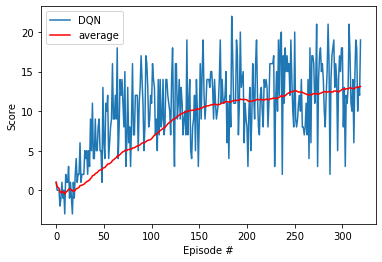

In [11]:
# plot the scores
plt.gcf()
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='DQN')
plt.plot(np.arange(len(scores)), avgs_moving, c='r', label='average')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');

plt.savefig('./images/training_scores.png')

plt.show()

### 5. Test!


In [12]:
# initialize the agent
agent = Agent(state_size=state_size, action_size=action_size, seed=42)

# load the weights from file
checkpoint = 'checkpoint.pth'
agent.qnetwork_local.load_state_dict(torch.load(checkpoint))

num_episodes = 10
scores = []
for i_episode in range(1,num_episodes+1):
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    
    score = 0                                          # initialize the score
    while True:
        action = agent.act(state, eps=0)               # select an action
        env_info = env.step(action.astype(int))[brain_name]        # send the action to the env
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # is episode done?

        score += reward                                # update the score
        state = next_state                             # set state to next state
        if done:                                       # are we done yet?
            scores.append(score)
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores)))
            break

Episode 1	Average Score: 12.00
Episode 2	Average Score: 7.50
Episode 3	Average Score: 9.67
Episode 4	Average Score: 8.50
Episode 5	Average Score: 9.40
Episode 6	Average Score: 10.50
Episode 7	Average Score: 9.29
Episode 8	Average Score: 9.62
Episode 9	Average Score: 9.44
Episode 10	Average Score: 9.50


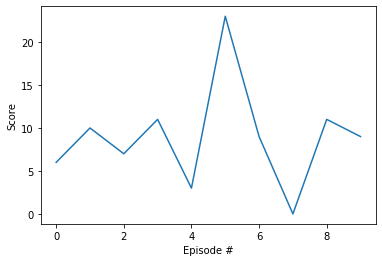

In [9]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.savefig('./images/testing_score.png')

plt.show()

When finished, you can close the environment.

In [10]:
env.close()

### 5. DQN improvements and Future work

Against some shortage of Basic DQN algorithm, there are three different improvements. For example

- Double DQN

Deep Q-Learning tends to overestimate action values. Double Q-Learning has been shown to work well in practice to help with this.

- Prioritized Experience Replay

Deep Q-Learning samples experience transitions uniformly from a replay memory. Prioritized Experience Replay is based on the idea that the agent can learn more effectively from some transitions than from others, and the more important transitions should be sampled with higher probability.

- Duelling DQN

Currently, in order to determine which states are (or are not) valuable, we have to estimate the corresponding action values for each action. However, by replacing the traditional Deep Q-Network (DQN) architecture with a duelling architecture, we can assess the value of each state, without having to learn the effect of each action.

For future improvement, I believe Dueling DQN would be very efficient.